In [1]:
import numpy as np
from keras.datasets import mnist
from keras.layers import Conv2D, Flatten, Activation, Dense, Input
from keras.layers import Conv2DTranspose
from keras.layers import Reshape
import matplotlib.pyplot as plt
from keras.models import Model

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = (28, 28, 1)

x_train = x_train.reshape((x_train.shape[0], ) + input_shape ) 
x_test = x_test.reshape((x_test.shape[0], ) + input_shape)

In [3]:
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
noise_test = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)

In [4]:
x_train_with_noise = np.clip((x_train + noise), 0., 1.)
x_test_with_noise = np.clip((x_test + noise_test), 0., 1.)

In [5]:
x_test_with_noise.shape

(10000, 28, 28, 1)

In [6]:
def get_shape(layer):
    shape = ()
    for i in layer.shape:
        shape += (i.value, )
    return shape

In [7]:
#encoder
encoder_inputs = Input(shape=input_shape)
x = encoder_inputs
x = Conv2D(filters=32,
               kernel_size=(3, 3),
               activation='relu',
               strides = 2,
               padding='same')(x)
x = Conv2D(filters=64,
               kernel_size=(3, 3),
               activation='relu',
               strides = 2,
               padding='same')(x)
shape = get_shape(x)
x = Flatten()(x)
output = Dense(16)(x)
encoder = Model(encoder_inputs, output, name='encoder')

In [8]:
input_from_encoder = Input(shape=(16,))
x = Dense(shape[1] * shape[2] * shape[3])(input_from_encoder)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=64,
                        kernel_size=(3, 3),
                        activation='relu',
                        strides = 2,
                        padding='same')(x)
x = Conv2DTranspose(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        strides = 2,
                        padding='same')(x)
x = Conv2DTranspose(filters=1,
                    kernel_size=(3, 3),
                    padding='same')(x)

output_image = Activation('sigmoid')(x)
decoder = Model(input_from_encoder, output_image, name='decoder')

In [9]:
autoencoder = Model(encoder_inputs, decoder(encoder(encoder_inputs)))

In [10]:
autoencoder.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
autoencoder.fit(x_train_with_noise,
                x_train,
                epochs=10,
                batch_size=256)


Epoch 1/10
60000/60000 [==============================] - 72s 1ms/step - loss: 0.0744 - accuracy: 0.8049
Epoch 2/10
60000/60000 [==============================] - 90s 2ms/step - loss: 0.0527 - accuracy: 0.7999
Epoch 3/10
60000/60000 [==============================] - 107s 2ms/step - loss: 0.0292 - accuracy: 0.8048
Epoch 4/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0236 - accuracy: 0.8079
Epoch 5/10
60000/60000 [==============================] - 95s 2ms/step - loss: 0.0213 - accuracy: 0.8091
Epoch 6/10
60000/60000 [==============================] - 98s 2ms/step - loss: 0.0200 - accuracy: 0.8098
Epoch 7/10
60000/60000 [==============================] - 102s 2ms/step - loss: 0.0191 - accuracy: 0.8102
Epoch 8/10
60000/60000 [==============================] - 105s 2ms/step - loss: 0.0184 - accuracy: 0.8106
Epoch 9/10
60000/60000 [==============================] - 88s 1ms/step - loss: 0.0179 - accuracy: 0.8108
Epoch 10/10
60000/60000 [=========================

In [11]:
test_image = x_test_with_noise[0]

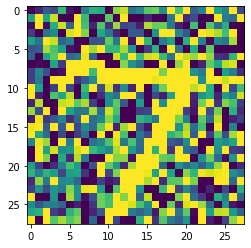

In [12]:
plt.imshow(test_image[:, :, 0])

In [13]:
clean = autoencoder.predict(test_image.reshape(1, 28, 28, 1))

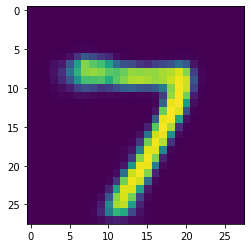

In [14]:
plt.imshow(clean[0, :, :, 0])

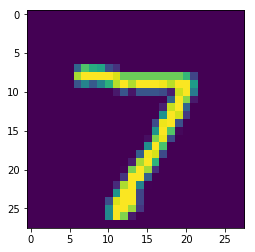

In [36]:
plt.imshow(x_test[0].reshape(28, 28))

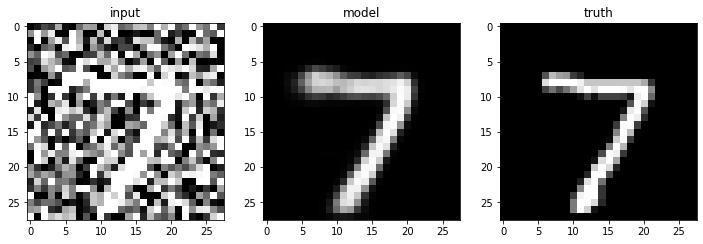

In [18]:
figure, axes = plt.subplots(1, 3, figsize=(12, 12))
axes[0].set_title("input")
axes[0].imshow(test_image[:, :, 0], cmap='gray')
axes[1].set_title("model")
axes[1].imshow(clean[0, :, :, 0], cmap='gray')
axes[2].set_title("truth")
axes[2].imshow(x_test[0].reshape(28, 28), cmap='gray')

In [26]:
from PIL import Image
Image.fromarray(np.uint8(x_test[0].reshape(28, 28) * 255)).convert("RGB").save("input.png")

In [25]:
from PIL import Image
Image.fromarray(np.uint8(test_image[:, :, 0].reshape(28, 28) * 255)).convert("RGB").save("noise.png")

In [27]:
from PIL import Image
Image.fromarray(np.uint8(clean[0, :, :, 0].reshape(28, 28) * 255)).convert("RGB").save("model.png")